Notebook Color Scheme: 


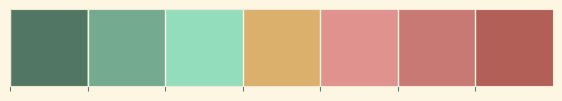

In [1]:
# 1. Handle datasets
import io
import os
import gc
import cv2
import time
import random
import pydicom
import dicomsdl
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import tifffile as tiff
import imageio.v3 as iio
import SimpleITK as sitk
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
from collections import Counter
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut

# 2. Visualize datasets
import datetime as dtime
from datetime import datetime
import itertools
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.figure_factory as pff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html

# 3. Preprocess datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
## import iterative impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
## fastai
# from fastai.data.all import *
# from fastai.vision.all import *

# 4. machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
## for classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from xgboost import XGBClassifier

# 5. Deep Learning
## Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

## Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50, ResNet50_Weights
from torchvision import datasets, transforms

# 6. metrics
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import f1_score, r2_score
from sklearn.metrics import classification_report

# 7. ignore warnings   
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 8. For displaying and wandb
import wandb
# wandb.login()
plt.style.use("Solarize_Light2")
plt.rcParams.update({'font.size': 16})

# 0. Customization
parent_dir = r"E:\rsna-breast-cancer-detection"
WANDB_PROJ_NAME = "RSNA_Breast_Cancer_Detection"
CONFIG = {
    'competition': 'RSNA_Breast_Cancer',
    '_wandb_kernel': 'aot'
}

my_colors = ['#517664', '#73AA90', '#94DDBC', '#DAB06C',
             '#DF928E', '#C97973', '#B25F57']
CMAP1 = ListedColormap(my_colors)
print("Notebook Color Scheme: ")
sns.palplot(sns.color_palette(my_colors))
plt.show()

#### Importing utility functions

In [2]:
import importlib
import utils
importlib.reload(utils)

from utils import set_seed, show_stacked_images, show_values_on_bars
from utils import save_dataset_artifact, create_wandb_plot, create_wandb_hist

In [3]:
df = pd.read_csv(os.path.join(parent_dir, "train.csv"))
df.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')

In [4]:
df['view'].unique().tolist()

['CC', 'MLO', 'ML', 'LM', 'AT', 'LMO']

## Data Preparation

#### 1. Label Encoding
**laterality**:
+ 0: L (Left)
+ 1: R (Right)

**view**:
+ 0: AT
+ 1: CC 
+ 2: MLO
+ 3: ML
+ 4: LM
+ 5: LMO

we will try to keep columns that presents in the test + target variable (meaning laterality and view)

#### Normal PNGs

In [5]:
# train_image_path = os.path.join(parent_dir, "train_image_processed_cv2_512")

# all_paths = []
# for k in tqdm(range(len(df))):
#     row = df.iloc[k, :]
#     all_paths.append(
#         os.path.join(
#             train_image_path, str(row.patient_id), f"{str(row.image_id)}.png"
#         ) 
#     )
    
# df['path'] = all_paths

### JP2000 format

In [6]:
train_image_path = os.path.join(parent_dir, "train_image_ROI_processed_jp2000_512")

all_paths = []
for k in tqdm(range(len(df))):
    row = df.iloc[k, :]
    all_paths.append(
        os.path.join(
            train_image_path, str(row.patient_id), f"{str(row.image_id)}.jp2"
        ) 
    )
    
df['path'] = all_paths

  0%|          | 0/54706 [00:00<?, ?it/s]

In [7]:
test_df = pd.read_csv(os.path.join(parent_dir, "test.csv"))
test_df.columns.to_list()

['site_id',
 'patient_id',
 'image_id',
 'laterality',
 'view',
 'age',
 'implant',
 'machine_id',
 'prediction_id']

In [8]:
df = df[
    ['patient_id', 'image_id', 'laterality', 'view', 'age', 'implant',
     "cancer", "path"]
]

le_laterality = LabelEncoder()
le_view = LabelEncoder()

df['laterality'] = le_laterality.fit_transform(df['laterality'])
df['view']       = le_view.fit_transform(df['view'])

df.head()

,patient_id,image_id,laterality,view,age,implant,cancer,path
0,10006,462822612,0,1,61.0,0,0,E:\rsna-breast-cancer-detection\train_image_RO...
1,10006,1459541791,0,5,61.0,0,0,E:\rsna-breast-cancer-detection\train_image_RO...
2,10006,1864590858,1,5,61.0,0,0,E:\rsna-breast-cancer-detection\train_image_RO...
3,10006,1874946579,1,1,61.0,0,0,E:\rsna-breast-cancer-detection\train_image_RO...
4,10011,220375232,0,1,55.0,0,0,E:\rsna-breast-cancer-detection\train_image_RO...


#### 2. Missing values

In [9]:
df.isnull().sum()

patient_id     0
image_id       0
laterality     0
view           0
age           37
implant        0
cancer         0
path           0
dtype: int64

'age' has 37 missing values. We can impute it with the mean and then normalize

In [10]:
df['age'].describe()

count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

In [11]:
df['age'] = df['age'].fillna(58)

This can be fast and simple, and also is a good technique when the missing values are just a few. However if the feature is skewed (missing values are not random), other approaches can prevent overfitting.

Here is the rule:

% Missing-------Action

< 1%------------Fill it, don't sweat it

1–5%------------Fill with median or imputer

\> 10%-----------Be cautious – maybe impute smartly or explore why it’s missing

\> 30%-----------Reconsider using the column at all unless it's critical

#### 3. Save Artifact

In [12]:
df.to_csv(os.path.join(parent_dir, "train_preprocessed.csv"), index=False)
WANDB_RUN = False
if WANDB_RUN:
    save_dataset_artifact(run_name = "save_train_prep",
                        artifact_name="train_prep",
                        path = os.path.join(parent_dir, "train_preprocessed.csv"),
                        projectName = WANDB_PROJ_NAME,
                        config = CONFIG,
                        data_type="dataset")

In [13]:
# Seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now: ', DEVICE)

# Read in Data
train = pd.read_csv(os.path.join(parent_dir, "train_preprocessed.csv"))
train.columns

Device available now:  cuda


Index(['patient_id', 'image_id', 'laterality', 'view', 'age', 'implant',
       'cancer', 'path'],
      dtype='object')

#### 4. Params

In [14]:
# ====== GLOBAL PARAMS =======
csv_columns = ["laterality", "view", "age", "implant"]
no_columns = len(csv_columns)
output_size = 1

## Training Prep

### 1. Dataset

### If use ROI-extracted files then no need for random crop
        # A.RandomResizedCrop(
        # size=(224, 224), 
        # scale=(0.08, 1.0), 
        # ratio=(0.75, 1.333), 
        # p=1.0
        # ),
        # A.ShiftScaleRotate(rotate_limit=9.0, scale_limit=[0.8, 1.2], p=1.0),

### == Resizing ==
        # A.Resize(224, 224), # Pretrained-model (ResNet, EfficientNet) < 224x224
        # But resizing can be bad since medical imaging may keen on original size

### === ALTERNATIVE TO RESIZING: Isotropic scaling ===

In [ ]:
from utils import transforms    # augmentation functions

In [24]:
class RSNADataset(Dataset):
    
    def __init__(self, dataFrame, isTrain = True, transforms=None):
        self.dataFrame, self.isTrain = dataFrame, isTrain
        self.metaData = self.dataFrame[csv_columns].to_numpy(dtype=np.float32)
        self.transforms = transforms  ## Data Augmentation
    
    def __len__(self):
        return len(self.dataFrame)
    
    def __getitem__(self, index):
        try:
            # Dealing with tabular
            csv_data = self.metaData[index]
            csv_data = torch.tensor(csv_data, dtype=torch.float32)
            
            # Dealing with images
            image_path = self.dataFrame['path'][index]
            if not os.path.exists(image_path):  # Check if image exists
                return self.__getitem__((index + 1) % len(self))
            
            image = cv2.imread(image_path)
            if image is None:
                return self.__getitem__((index + 1) % len(self))  # Pass if img is None
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # == AUGMENTATION ==
            # Dealing with imbalanced data
            label = self.dataFrame.loc[index]['cancer']
            isMinority = (label == 1)
            
            # == AUGMENTATION ==
            if self.isTrain:
                image = self.transforms(
                    isMinority=isMinority, isTrain=True
                )(image=image)['image']
            else:
                image = self.transforms(isTrain=False)(image=image)['image']

            if self.isTrain:
                return {
                    "image": image, 
                    "meta": csv_data, 
                    "target": self.dataFrame['cancer'][index]
                }
            else:
                return {
                    "image": image, 
                    "meta": csv_data, 
                }
        except Exception as e:
            print(f"[ERROR] Failed at index {index}: {e}")
            if self.isTrain:
                return {
                    "image": torch.zeros(3, 224, 224), 
                    "meta": torch.zeros(no_columns),
                    "target": torch.tensor(0)
                }
            else:
                return {
                    "image": torch.zeros(3, 224, 224), 
                    "meta": torch.zeros(no_columns), 
                }

In [17]:
def data_to_device(data):
    image, metadata, targets = data.values()
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

### 2. Sanity Check
to catch dumb mistakes early

Batch: 0 
 Image: torch.Size([12, 3, 224, 224]) 
 Meta: tensor([[ 0.,  1., 61.,  0.],
        [ 0.,  5., 61.,  0.],
        [ 1.,  5., 61.,  0.],
        [ 1.,  1., 61.,  0.],
        [ 0.,  1., 55.,  0.],
        [ 0.,  5., 55.,  0.],
        [ 1.,  1., 55.,  0.],
        [ 1.,  5., 55.,  0.],
        [ 0.,  1., 75.,  0.],
        [ 0.,  5., 75.,  0.],
        [ 1.,  1., 75.,  0.],
        [ 1.,  5., 75.,  0.]], device='cuda:0') 
 Targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


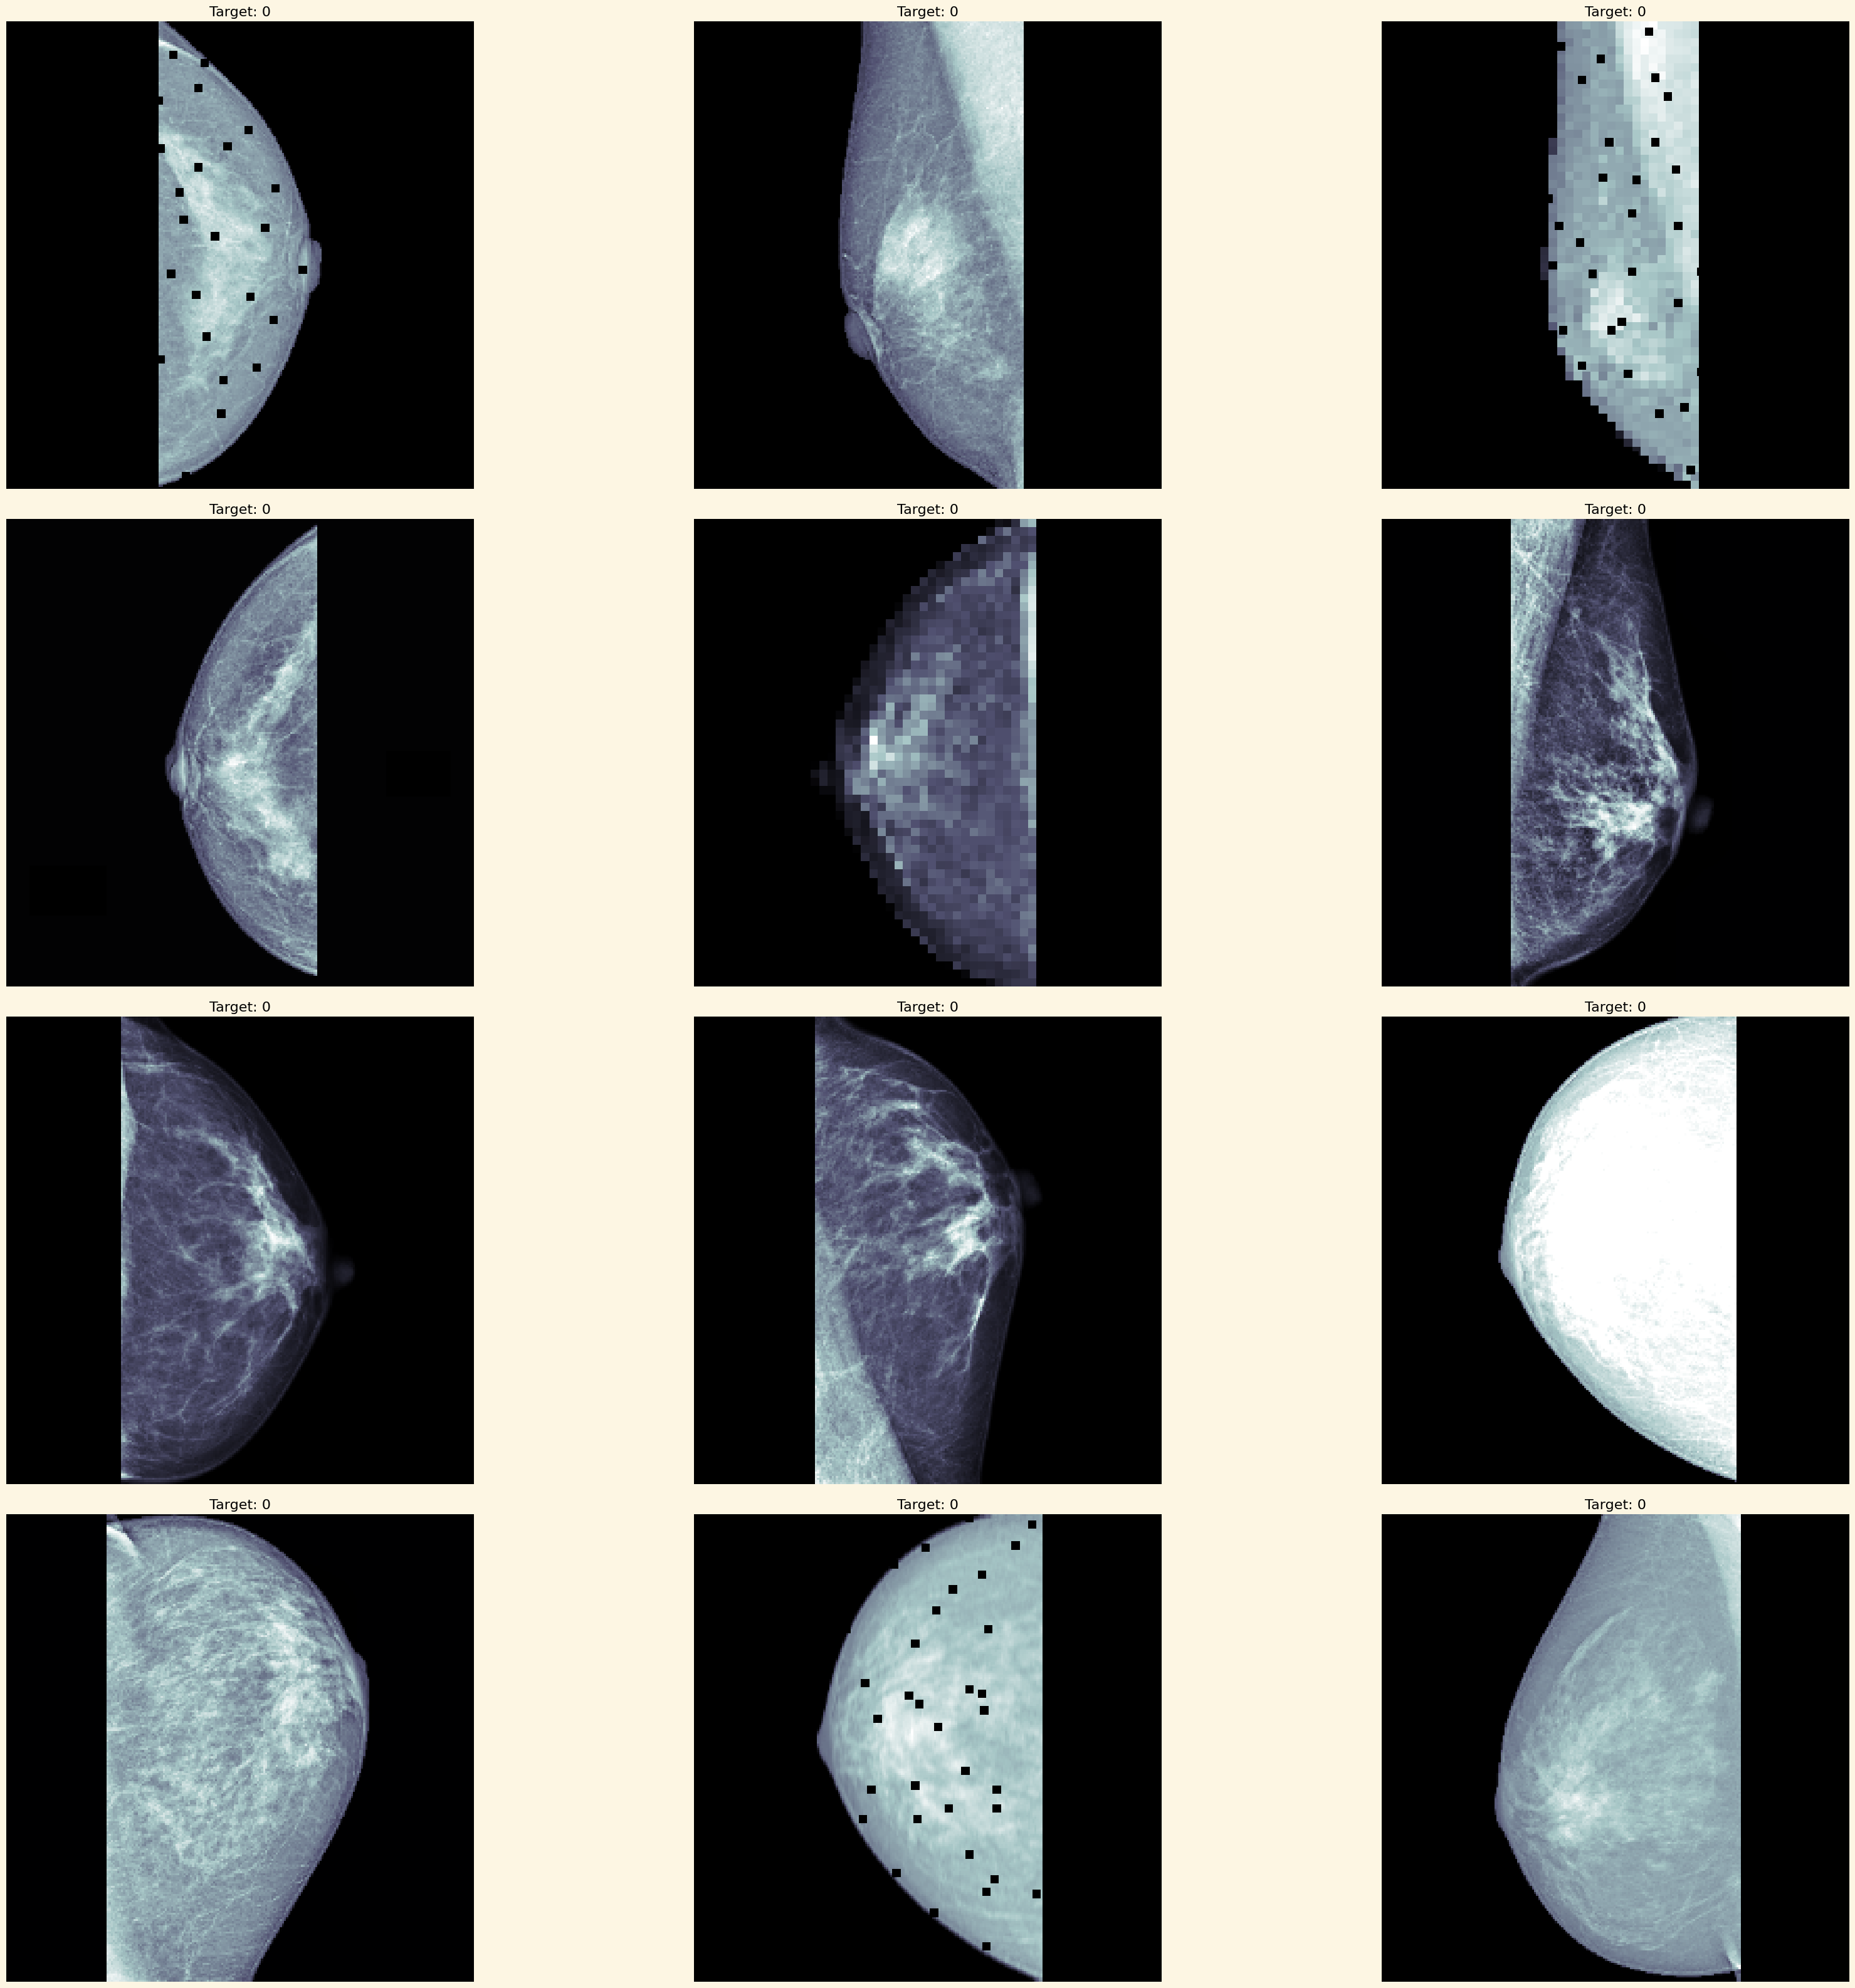

In [27]:
train_data = train.reset_index(drop=True).head(12)
dataset = RSNADataset(
    dataFrame = train_data, 
    isTrain = True, 
    transforms=transforms
)
dataLoader = DataLoader(dataset, batch_size=32, shuffle=False, pin_memory=True)

for i, data in enumerate(dataLoader):
    image, meta, targets = data_to_device(data)
    print(f"Batch: {i} \n Image: {image.shape} \n Meta: {meta} \n Targets: {targets}")
    print("="*50)
    
    show_stacked_images(image, targets)

### 3. ResNet

In [ ]:
from utils import ResNet50Network

##### Sanity Check

In [ ]:
# Load model
model_example = ResNet50Network(
    outSize=output_size,
    no_columns=no_columns
).to(DEVICE)

out = model_example(image, meta, prints=True)

criterion_example = nn.BCEWithLogitsLoss()
loss = criterion_example(out, targets.unsqueeze(1).float())

print("="*50)
print(f"Loss = {loss.item()}")

Input Image Shape: torch.Size([12, 3, 224, 224]) 
 Input Metadata Shape: torch.Size([12, 4])


KeyboardInterrupt: 

### 4. EffNet

**Problem with CNNs as a whole**: They train on fixed resource cost and scaled up when more resource are available. The scaling up - increase arbitrary the depth or width of the CNN, then manually tune -> This is not optimal

EffNet uses a compound coefficient in a more structured manner.

+ uniformly scale each dimension (w, h, resolution) with a fixed set of scaling coefficients.

+ This is much more efficient than scaling only 1 dimension at the time.

EffNet also uses AutoML:

+ Automated Machine Learning

+ Reinforcement Learning

In [ ]:
from utils import EffNetNetwork

#### sanity checking

In [ ]:
model_example_2 = EffNetNetwork(outputSize=output_size,
                                no_columns=no_columns).to(DEVICE)

out = model_example_2(image, meta, prints=True)

criterion_example = nn.BCEWithLogitsLoss()
loss = criterion_example(out, targets.unsqueeze(1).float())
print("="*50)
print(f"Loss = {loss.item()}")

Loaded pretrained weights for efficientnet-b3
Input Image Shape: torch.Size([12, 3, 224, 224]) 
 Input Metadata Shape: torch.Size([12, 4])
Features image shape: torch.Size([12, 1536])
Metadata shape: torch.Size([12, 250])
Concatenated data: torch.Size([12, 1786])
Out shape: torch.Size([12, 1])
Loss = 0.836770236492157


## Vision Transformer - ViT
In medical imaging, *Vision Transformers (ViTs)* have demonstrated *superior* performance over EfficientNet models in various diagnostic tasks. For instance, in differentiating benign from malignant lesions in PET/CT scans, ViTs achieved an AUC of *0.90*, outperforming EfficientNet's 0.87 . Similarly, a hybrid model *combining EfficientNetV2 with a ViT* achieved an accuracy of 98.10% in breast cancer detection, surpassing the individual performance of EfficientNetV2. 

### 1. Define The Patch Embedding Layer

In [ ]:
# class PatchEmbedding(nn.Module):
#     def __init__(self, imgSize, patchSize, inChannels, embeddedDim):
#         super(PatchEmbedding, self).__init__()
#         self.imgSize, self.imgSize = imgSize, patchSize
#         self.inChannels, self.embeddedDim = inChannels, embeddedDim
#         self.proj = nn.Conv2d(inChannels, embeddedDim, kernel_size=patchSize, stride=patchSize)
    
#     def forward(self, x):
#         x = self.proj(x)
#         x = x.flatten(2)
#         x = x.transpose(1, 2)  # Shape: (B, num_patches, embed_dim)
#         return x 

### 2. Implement the transformer Encoder

In [ ]:
# class TransformerEncoder(nn.Module):
    
#     def __init__(self, embeddedDim, num_heads, num_layers):
#         super(TransformerEncoder, self).__init__()
        
#         encoder_layers = nn.TransformerEncoderLayer(
#             d_model=embeddedDim,
#             nhead=num_heads,
#             dim_feedforward=2048
#         )
#         self.encoder = nn.TransformerEncoder(
#             encoder_layer=encoder_layers,
#             num_layers=num_layers
#         )
        
#     def forward(self, x):
#         return self.encoder(x)

### 3. Construct the ViT Model
Patch embedding + transformer encoder + classification head.

In [ ]:
# class VisionTransformer(nn.Module):
    
#     def __init__(self, imgSize, patchSize, inChannels, embeddedDim, num_heads, num_layers, num_classes):
#         super(VisionTransformer, self).__init__()
        
#         self.patchEmbedded = PatchEmbedding(imgSize, patchSize, inChannels, embeddedDim)
#         self.encoder = TransformerEncoder(embeddedDim, num_heads, num_layers)
#         self.fc = nn.Linear(embeddedDim, num_classes)
        
#         self.cls_token = nn.Parameter(torch.zeros(1, 1, embeddedDim))
#         self.pos_embed = nn.parameter(torch.zeros(1, (imgSize / patchSize) ** 2 + 1, embeddedDim))
    
#     def forward(self, x):
#         x = self.patchEmbedded(x)
#         cls_token = self.cls_token.expand(x.size(0), -1, -1)
        
#         x = torch.cat((cls_token, x), dim=1)
#         x = x + self.pos_embed
#         x = self.encoder(x)
        
#         cls_outputs = x[:, 0]
#         logits = self.fc(cls_outputs)
#         return logits
        

In [ ]:
## Or use a pre trained ViT from gg
from utils import ViTNetwork

#### Sanity Check

In [ ]:
model_example_3 = ViTNetwork(outSize=output_size,
                                no_columns=no_columns).to(DEVICE)

out = model_example_3(image, meta, prints=True)

criterion_example = nn.BCEWithLogitsLoss()
loss = criterion_example(out, targets.unsqueeze(1).float())
print("="*50)
print(f"Loss = {loss.item()}")

Input Image Shape: torch.Size([12, 3, 224, 224]) 
 Input Metadata Shape: torch.Size([12, 4])
ViT output shape: torch.Size([12, 768])
Metadata output shape: torch.Size([12, 250])
Concatenated shape: torch.Size([12, 1018])
Final output shape: torch.Size([12, 1])
Loss = 0.6069353222846985


## Training

#### Params

In [ ]:
FOLDS = 3
EPOCHS = 20
MIN_THRESHOLD_EPOCHS = 7
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1
LR_FACTOR = 0.4

BATCH_SIZE1 = 64
BATCH_SIZE2 = 32

#### Small function to save in an external file

In [ ]:
1536 + 250

1786

In [ ]:
def add_in_file(text, f, trial):
    with open(f"logs_{VERSION}_trial_{trial}.txt", "a+") as f:
        print(text, file=f)

In [ ]:
def train_folds(model, train_original, lr, batch_size, trial, epochs=3):
    
    topModels = []
    
    def saveBestModel(foldNum, epochNum, valid_acc, f1Score, best_roc, model = model, VERSION = VERSION):
        model_name = f"{VERSION}_Fold{foldNum}_Epoch{epochNum}_ValidAcc{valid_acc:.3f}_F1{f1Score:.3f}_ROC{best_roc:.3f}.pth"
        torch.save(model.state_dict(), model_name)
        
        topModels.append((model_name, best_roc))
        topModels.sort(key=lambda x: x[1], reverse=True)
        
        if len(topModels) > 3:
            removedModel = topModels.pop()  # Removing the worst ROC based model
            os.remove(removedModel[0])
            print(f"Deleted worst model: {removedModel[0]}")
    
    
    def create_dataloader(dataset, batch_size=32, shuffle = False, sampler = None):
        return DataLoader(dataset, 
                        batch_size, 
                        shuffle, 
                        sampler=sampler,
                        # num_workers=16,
                        pin_memory=True,
                        # persistent_workers=True,
                        # prefetch_factor=2
        )
        
            
    def trainFunction(epoch):
        model.train()
        total_loss, correct = 0.0, 0.0
        
        progBar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        for data in progBar:
            image, meta, targets = data_to_device(data)
            
            optimizer.zero_grad()
            out = model(image, meta)
            loss = criterion(out, targets.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_preds = torch.round(torch.sigmoid(out))
            correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()
            
            # Save information
            wandb.log({'train_loss': total_loss})
            progBar.set_description(f'loss: {total_loss:.2f}')
            

        train_acc = correct / len(train_index)
        wandb.log({"train_acc": train_acc})
        return train_acc, total_loss
           
           
    def validFunction(epoch, train_acc, total_loss):
        nonlocal best_roc, patience_f
        
        model.eval()
        preds_tensor = torch.zeros(len(valid_data), 1, device=DEVICE, dtype=torch.float32)
        
        progBar = tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]", leave=False)
        with torch.no_grad():
            for k, data in enumerate(progBar):
                image, meta, targets = data_to_device(data)
                out = model(image, meta)
                preds = torch.sigmoid(out)
                preds_tensor[k * image.shape[0]: (k+1) * image.shape[0]] = preds
                
        pred_bin = torch.round(preds_tensor.cpu())
        valid_labels = valid_data['cancer'].values
        acc = accuracy_score(valid_labels, pred_bin)
        roc = roc_auc_score(valid_labels, preds_tensor.cpu())
        f1 = f1_score(valid_labels, pred_bin)
                
        wandb.log({"valid_acc": acc})
        wandb.log({"valid_roc": roc})
        wandb.log({"valid_F1Score": f1})
                
        # Print info
        duration = str(time.time() - start_time)[:7]
        log = f'{duration} | Epoch: {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Acc_tr: {train_acc:.3f} | Acc_vd: {acc:.3f} | ROC: {roc:.3f} | F1: {f1:.3f}'
        print(log)
        add_in_file(log, f, trial=trial)
         
        # Update scheduler (for learning_rate)
        scheduler.step(roc)      
         
        #=== SAVE MODEL===
                
        # Update best Roc
        # If best_roc = None
        if best_roc is None or roc > best_roc: 
            best_roc = roc
            saveBestModel(foldNum=i+1, epochNum=epoch+1, valid_acc=acc, f1Score=f1, best_roc=best_roc, model = model, VERSION = VERSION)
            print(f"Saved new best model at Epoch {epoch+1}")
            return best_roc, PATIENCE
            
        else:
            return best_roc, patience_f - 1
    
    
    with open(f"logs_{VERSION}.txt", "w+") as f:
        f = open(f"logs_{VERSION}.txt", "w+")
        print(f"Training with learning rate: {lr} and batch size: {batch_size}")
    
    # SHUFFLE BEFORE SPLITTING
    train_original = train_original.sample(frac=1, random_state=42).reset_index(drop=True)

    # Generate indices to split data into training and test set
    group_fold = GroupKFold(n_splits=FOLDS)
    k_folds = group_fold.split(X=np.zeros(len(train_original)),
                               y=train_original['cancer'],
                               groups=train_original['patient_id'].tolist())
    
    for i, (train_index, valid_index) in enumerate(k_folds):
        print(f"-------- Fold: {i+1} --------")
        add_in_file(f"-------- Fold: {i+1} --------", f, trial=trial)
        
        # == WANDB Tracking == 
        RUN_CONFIG = CONFIG.copy()
        params = dict(
            model=MODEL,
            version=VERSION,
            fold=i,
            epochs=epochs,
            batch=batch_size,
            lr=lr,
            weight_decay=WD
        )
        RUN_CONFIG.update(params)
        wandb.init(project=WANDB_PROJ_NAME, config=RUN_CONFIG)
        wandb.watch(model, log_freq=100)
        
        # == Create Instances ==
        best_roc = None
        patience_f = PATIENCE
        current_model = model # Use a fresh model for each fold

        # == Read in data ==
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        # Loss Weights for imbalanced data
        neg, pos = train_data['cancer'].value_counts()
        pos_weight = torch.tensor([neg / pos], dtype=torch.float).to(DEVICE)

        # == OPTIMIZER, SCHEDULER, LOSS_FUNCTION ==
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode="max", patience=LR_PATIENCE, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        # == Create Data Instances ==
        train = RSNADataset(train_data, isTrain=True, transforms=transforms)
        valid = RSNADataset(valid_data, isTrain=True, transforms=transforms)
        
        # compute weights for imbalanced data
        class_counts = train_data['cancer'].value_counts()
        class_weights = 1. / class_counts
        sample_weights = train_data['cancer'].map(lambda x: class_weights[x])
            
        # Create sampler
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=sample_weights.values,
            num_samples=len(sample_weights),
            replacement=True,
        )
        
        # == Data Loaders ==
        train_loader = create_dataloader(train, sampler=sampler)
        valid_loader = create_dataloader(valid, shuffle=False)
        
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # == TRAIN ==
            train_acc, total_loss = trainFunction(epoch)
            
            # === EVALUATION ===
            best_roc, patience_f = validFunction(epoch, train_acc, total_loss)
            
            # === EARLY STOPPING ===
            if epoch + 1 > MIN_THRESHOLD_EPOCHS and patience_f == 0:
                msg = f"Early stopping | Best ROC: {best_roc:.4f}"
                print(msg)
                add_in_file(msg, f, trial=trial)
                break
        
        # === CLEANING ===
        # Clear memory
        for var_name in ['train', 'valid', 'train_loader', 'valid_loader', 'image', 'targets']:
            if var_name in locals():
                del locals()[var_name]
        gc.collect()
        
        # Finalize Wandb
        wandb.finish()

    return best_roc

### Sanity check for training function

In [ ]:
# import logging
# import time
# import os
# from tqdm import tqdm

# FOLDS = 3
# EPOCHS = 20
# MIN_THRESHOLD_EPOCHS = 5
# PATIENCE = 3
# WORKERS = 8
# LR = 0.0005
# WD = 0.0
# LR_PATIENCE = 1
# LR_FACTOR = 0.4

# BATCH_SIZE1 = 64
# BATCH_SIZE2 = 32

# if __name__ == '__main__':

#     # Setup logging configuration
#     log_file = "sanity_check_log.txt"
#     logging.basicConfig(filename=log_file, level=logging.INFO, 
#                         format="%(asctime)s - %(levelname)s - %(message)s")

#     def log_and_print(message):
#         """Logs and prints messages to track code execution."""
#         print(message)
#         logging.info(message)

#     # Select a small subset for one fold (e.g., the first 2 samples)
#     sample_train_data = train.head(2)
#     sample_valid_data = train.head(2)

#     log_and_print("Starting the sanity check with a small subset of data...")

#     # Create Dataset instances for training and validation (with simplified batch size)
#     train_dataset = RSNADataset(sample_train_data, isTrain=True, transforms=transforms(isTrain=True))
#     valid_dataset = RSNADataset(sample_valid_data, isTrain=True, transforms=transforms(isTrain=True))

#     log_and_print("Dataset instances created for training and validation.")

#     # Function to create DataLoader
#     def create_dataloader(dataset):
#         """Create a new DataLoader instance."""
#         return DataLoader(dataset, 
#                         batch_size=3, 
#                         shuffle=False, 
#                         num_workers=2,
#                         pin_memory=True)

#     # Initialize Model and Optimizer
#     model_example = ResNet50Network(outSize=output_size, no_columns=no_columns).to(DEVICE)
#     optimizer = torch.optim.Adam(model_example.parameters(), lr=LR, weight_decay=WD)
#     criterion = nn.BCEWithLogitsLoss()

#     log_and_print("Model, optimizer, and criterion initialized.")

#     # Train for one epoch to check if everything works
#     for epoch in range(1):  # Run only one epoch for the test
#         start_time = time.time()
#         log_and_print(f"Epoch {epoch+1} started. Training Loop...")

#         # === Training Loop ===
#         model_example.train()
#         correct_train = 0
#         train_loss = 0
#         step = 0  # Keep track of how many batches we've processed
        
        
#         # Initialize DataLoader and iterate over it
#         train_loader = create_dataloader(train_dataset)
#         valid_loader = create_dataloader(valid_dataset)
#         train_loader_iter = iter(train_loader)
        

#         while step < len(train_loader):  # Continue until we process all the data
#             try:
#                 data = next(train_loader_iter)  # Try fetching the next batch
#                 images, meta, targets = data_to_device(data)

#                 optimizer.zero_grad()
#                 out = model_example(images, meta)

#                 loss = criterion(out, targets.unsqueeze(1).float())
#                 loss.backward()
#                 optimizer.step()

#                 train_loss += loss.item()

#                 # Calculate accuracy
#                 preds = torch.round(torch.sigmoid(out))
#                 correct_train += (preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()

#                 step += 1
#             except Exception as e:
#                 # If a worker fails, recreate the DataLoader and restart iteration
#                 log_and_print(f"Worker failed at step {step}. Re-creating DataLoader: {e}")
#                 train_loader = create_dataloader(train_dataset)  # Pass the dataset argument here
#                 train_loader_iter = iter(train_loader)  # Restart iteration

#         # Calculate training accuracy
#         train_acc = correct_train / len(sample_train_data)
#         log_and_print(f"Training completed. Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f}")

#         # === Validation Loop ===
#         model_example.eval()
#         correct_valid = 0
#         valid_preds = torch.zeros(len(sample_valid_data), 1, device=DEVICE)

#         with torch.no_grad():
#             for i, data in enumerate(valid_loader):
#                 if i % 10 == 0:  # Every 10 batches, print a progress update
#                     log_and_print(f"Validating batch {i+1}...")

#                 images, meta, targets = data_to_device(data)

#                 out = model_example(images, meta)
#                 preds = torch.sigmoid(out)

#                 valid_preds[i * images.shape[0] : (i+1) * images.shape[0]] = preds

#                 correct_valid += (torch.round(preds) == targets.unsqueeze(1)).sum().item()

#         # Calculate validation accuracy
#         valid_acc = correct_valid / len(sample_valid_data)
        
#         # Calculate ROC for validation
#         valid_roc = roc_auc_score(sample_valid_data['cancer'].values, valid_preds.cpu())

#         # Calculate epoch duration
#         duration = str(time.time() - start_time)[:7]

#         log_and_print(f"Epoch {epoch+1} completed. Duration: {duration}s | "
#                     f"Valid Acc: {valid_acc:.3f} | Valid ROC: {valid_roc:.3f}")

#         # Save model after each epoch if needed
#         model_name = f"test_epoch{epoch+1}_train_acc{train_acc:.3f}_valid_acc{valid_acc:.3f}_roc{valid_roc:.3f}.pth"
#         # torch.save(model_example.state_dict(), model_name)

#         # Clear memory after each epoch
#         del train_loader, valid_loader, images, targets, out
#         gc.collect()

#     log_and_print("Sanity check completed.")

## Experimenting

### Resnet

In [ ]:
# VERSION = 'v1'
# MODEL = 'resnet50'

# model1 = ResNet50Network(outSize=output_size, no_columns=no_columns).to(DEVICE)

# #---------------------------------------------------------------------------------------
# def objective(trial):
#     # Define hyperparameters to tune
#     trial_number = trial.number
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32])
    
#     # Initialize the model
#     model = ResNet50Network(outSize=output_size, no_columns=no_columns).to(DEVICE)
    
#     # Train and validate the model
#     best_roc = train_folds(
#         model, 
#         train_original=train, 
#         lr=lr, 
#         batch_size=batch_size, 
#         trial = trial_number,
#         epochs=EPOCHS
#     )
    
#     return best_roc

# #---------------------------------------------------------------------------------------
# study = optuna.create_study(direction='maximize')  # Maximize ROC AUC
# study.optimize(objective, n_trials=2)
# print("Best hyperparameters: ", study.best_params)

# f = open("logs_v1.txt", "r")
# contents = f.read()
# print(contents)

### Efficient Net

In [ ]:
# VERSION = 'v4'
# MODEL = 'effnet50'

# #---------------------------------------------------------------------------------------
# def objective(trial):
#     # Define hyperparameters to tune
#     trial_number = trial.number
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-4)
#     batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
#     # Initialize the model
#     model = EffNetNetwork(outputSize=output_size, no_columns=no_columns).to(DEVICE)
    
#     # Train and validate the model
#     best_roc = train_folds(
#         model, 
#         train_original=train, 
#         lr=lr, 
#         batch_size=batch_size, 
#         trial = trial_number,
#         epochs=EPOCHS
#     )
    
#     return best_roc

# #---------------------------------------------------------------------------------------
# study = optuna.create_study(direction='maximize')  # Maximize ROC AUC
# study.optimize(objective, n_trials=2)
# print("Best hyperparameters: ", study.best_params)

# best_trial = study.best_trial.number
# with open(f"logs_{VERSION}_trial_{best_trial}.txt", "r") as f:
#     contents = f.read()
#     print(contents)

## ViT

In [ ]:
# VERSION = 'v4'
# MODEL = 'ViTNetwork'

# #---------------------------------------------------------------------------------------
# def objective(trial):
#     # Define hyperparameters to tune
#     trial_number = trial.number
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
#     batch_size = trial.suggest_categorical('batch_size', [128])
    
#     # Initialize the model
#     model = ViTNetwork(outSize=output_size, no_columns=no_columns).to(DEVICE)
    
#     # Train and validate the model
#     best_roc = train_folds(
#         model, 
#         train_original=train, 
#         lr=lr, 
#         batch_size=batch_size, 
#         trial = trial_number,
#         epochs=EPOCHS
#     )
    
#     return best_roc

# #---------------------------------------------------------------------------------------
# study = optuna.create_study(direction='maximize')  # Maximize ROC AUC
# study.optimize(objective, n_trials=2)        
# print("Best hyperparameters: ", study.best_params)

# f = open("logs_v1.txt", "r")
# contents = f.read()
# print(contents)

## Experimenting with EffNetV2 and some new - updated codes

**New Code:**

+ Model Ensembling: The new code introduces model ensembling (majority voting or soft voting) at the end of the folds. Warning: this is a powerful technique, but will significantly increases computational costs.

+ The models are stored, and once all folds are trained, predictions from all the best models are aggregated. This means that for each fold, multiple models are saved, and you need to do predictions using each model during the final ensembling step. This leads to higher memory and compute requirements.

+ Soft Voting (which averages the predictions) or Hard Voting (which takes the mode of predictions) require multiple forward passes through the models after training, which is costly when you have multiple models.

+ Soft Voting involves computing the average of the outputs from the multiple models, which requires extra memory and extra compute for combining the predictions.

+ Since the code saves the top 3 models and uses them later, this introduces more complexity and can slow down the process, particularly when multiple models are involved in the final step.

In [ ]:
# from sklearn.model_selection import GroupKFold
# from scipy.stats import mode

# # =======================================
# # 1. Define Ensembling Function (Majority Voting / Soft Voting)
# # =======================================
# def ensemble_predict(models, test_data, voting_type='soft'):
#     models = [model.to(DEVICE).eval() for model in models]
#     all_preds = []

#     with torch.no_grad():
#         for model in models:
#             predictions = model(test_data)
#             all_preds.append(predictions)

#     if voting_type == 'soft':
#         avg_preds = torch.stack(all_preds).mean(dim=0)
#         return avg_preds

#     elif voting_type == 'hard':
#         preds = [torch.argmax(pred, dim=1) for pred in all_preds]
#         stacked_preds = torch.stack(preds)
#         final_preds, _ = mode(stacked_preds, dim=0)
#         return final_preds.squeeze(0)

# # =======================================
# # 2. Modify `train_folds` to save top 3 models
# # =======================================
# def train_folds(model, train_original, lr, batch_size, trial, epochs=3):
    
#     topModels = []

#     def saveBestModel(foldNum, epochNum, valid_acc, f1Score, best_roc, model=model, VERSION=VERSION):
#         model_name = f"{VERSION}_Fold{foldNum}_Epoch{epochNum}_ValidAcc{valid_acc:.3f}_F1{f1Score:.3f}_ROC{best_roc:.3f}.pth"
#         torch.save(model.state_dict(), model_name)
        
#         topModels.append((model_name, best_roc))
#         topModels.sort(key=lambda x: x[1], reverse=True)
        
#         if len(topModels) > 3:
#             removedModel = topModels.pop()
#             os.remove(removedModel[0])
#             print(f"Deleted worst model: {removedModel[0]}")

#     def create_dataloader(dataset, batch_size=32, shuffle=False, sampler=None):
#         return DataLoader(dataset, batch_size, shuffle, sampler=sampler, pin_memory=True)

#     def trainFunction(epoch):
#         model.train()
#         total_loss, correct = 0.0, 0.0
#         progBar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        
#         for data in progBar:
#             image, meta, targets = data_to_device(data)
#             optimizer.zero_grad()
#             out = model(image, meta)
#             loss = criterion(out, targets.unsqueeze(1).float())
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
#             train_preds = torch.round(torch.sigmoid(out))
#             correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()
#             wandb.log({'train_loss': total_loss})
#             progBar.set_description(f'loss: {total_loss:.2f}')

#         train_acc = correct / len(train_index)
#         wandb.log({"train_acc": train_acc})
#         return train_acc, total_loss
    
#     def validFunction(epoch, train_acc, total_loss):
#         nonlocal best_roc, patience_f
#         model.eval()
#         preds_tensor = torch.zeros(len(valid_data), 1, device=DEVICE, dtype=torch.float32)
        
#         progBar = tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]", leave=False)
#         with torch.no_grad():
#             for k, data in enumerate(progBar):
#                 image, meta, targets = data_to_device(data)
#                 out = model(image, meta)
#                 preds = torch.sigmoid(out)
#                 preds_tensor[k * image.shape[0]: (k + 1) * image.shape[0]] = preds
                
#         pred_bin = torch.round(preds_tensor.cpu())
#         valid_labels = valid_data['cancer'].values
#         acc = accuracy_score(valid_labels, pred_bin)
#         roc = roc_auc_score(valid_labels, preds_tensor.cpu())
#         f1 = f1_score(valid_labels, pred_bin)
                
#         wandb.log({"valid_acc": acc})
#         wandb.log({"valid_roc": roc})
#         wandb.log({"valid_F1Score": f1})
        
#         duration = str(time.time() - start_time)[:7]
#         log = f'{duration} | Epoch: {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Acc_tr: {train_acc:.3f} | Acc_vd: {acc:.3f} | ROC: {roc:.3f} | F1: {f1:.3f}'
#         print(log)
#         add_in_file(log, f, trial=trial)
        
#         scheduler.step(roc)
        
#         if best_roc is None or roc > best_roc:
#             best_roc = roc
#             saveBestModel(foldNum=i+1, epochNum=epoch+1, valid_acc=acc, f1Score=f1, best_roc=best_roc, model=model, VERSION=VERSION)
#             print(f"Saved new best model at Epoch {epoch+1}")
#             return best_roc, PATIENCE
#         else:
#             return best_roc, patience_f - 1
    
#     with open(f"logs_{VERSION}.txt", "w+") as f:
#         print(f"Training with learning rate: {lr} and batch size: {batch_size}")
    
#     train_original = train_original.sample(frac=1, random_state=42).reset_index(drop=True)

#     group_fold = GroupKFold(n_splits=FOLDS)
#     k_folds = group_fold.split(X=np.zeros(len(train_original)), y=train_original['cancer'], groups=train_original['patient_id'].tolist())
    
#     for i, (train_index, valid_index) in enumerate(k_folds):
#         print(f"-------- Fold: {i+1} --------")
#         add_in_file(f"-------- Fold: {i+1} --------", f, trial=trial)
        
#         RUN_CONFIG = CONFIG.copy()
#         params = dict(model=MODEL, version=VERSION, fold=i, epochs=epochs, batch=batch_size, lr=lr, weight_decay=WD)
#         RUN_CONFIG.update(params)
#         wandb.init(project=WANDB_PROJ_NAME, config=RUN_CONFIG)
#         wandb.watch(model, log_freq=100)
        
#         best_roc = None
#         patience_f = PATIENCE
#         current_model = model
        
#         train_data = train_original.iloc[train_index].reset_index(drop=True)
#         valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
#         neg, pos = train_data['cancer'].value_counts()
#         pos_weight = torch.tensor([neg / pos], dtype=torch.float).to(DEVICE)

#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WD)
#         scheduler = ReduceLROnPlateau(optimizer=optimizer, mode="max", patience=LR_PATIENCE, factor=LR_FACTOR)
#         criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
#         train = RSNADataset(train_data, isTrain=True, transforms=transforms)
#         valid = RSNADataset(valid_data, isTrain=True, transforms=transforms)
        
#         class_counts = train_data['cancer'].value_counts()
#         class_weights = 1. / class_counts
#         sample_weights = train_data['cancer'].map(lambda x: class_weights[x])
            
#         sampler = torch.utils.data.WeightedRandomSampler(
#             weights=sample_weights.values, 
#             num_samples=len(sample_weights), 
#             replacement=True
#         )
        
#         train_loader = create_dataloader(train, sampler=sampler)
#         valid_loader = create_dataloader(valid, shuffle=False)
        
#         for epoch in range(epochs):
#             start_time = time.time()
#             train_acc, total_loss = trainFunction(epoch)
#             best_roc, patience_f = validFunction(epoch, train_acc, total_loss)
            
#             if epoch + 1 > MIN_THRESHOLD_EPOCHS and patience_f == 0:
#                 msg = f"Early stopping | Best ROC: {best_roc:.4f}"
#                 print(msg)
#                 add_in_file(msg, f, trial=trial)
#                 break
        
#         for var_name in ['train', 'valid', 'train_loader', 'valid_loader', 'image', 'targets']:
#             if var_name in locals():
#                 del locals()[var_name]
#         gc.collect()
        
#         wandb.finish()

#     return topModels

# # =======================================
# # 3. Combine Best Models with Ensembling
# # =======================================
# def ensemble_models(models, test_data, voting_type='soft'):
#     soft_preds = ensemble_predict(models, test_data, voting_type='soft')
#     return soft_preds

# # =======================================
# # 4. Utilize all and train
# # =======================================

# VERSION = 'v5'
# MODEL = 'effnet50'

# # Optimization using Optuna
# def objective(trial):
#     trial_number = trial.number
#     lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
#     batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
#     model = EffNetNetwork(outputSize=output_size, no_columns=no_columns).to(DEVICE)
    
#     # Train the model and get top models from all folds
#     top_models = train_folds(
#         model, train_original=train, 
#         lr=lr, batch_size=batch_size, trial=trial_number, epochs=EPOCHS
#     )
    
#     # Combine the top models into an ensemble and get predictions
#     ensemble_preds = ensemble_models([model for model, _ in top_models], test_data=test_df)
    
#     # If using ROC-AUC, you can evaluate the performance on the test set (test_df)
#     # Assuming `test_df['cancer']` is the true labels for the test set
#     true_labels = test_df['cancer'].values
#     roc_score = roc_auc_score(true_labels, ensemble_preds.cpu().numpy())
    
#     # Return the ROC score of the ensemble predictions for optimization
#     return roc_score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=2)
# print("Best hyperparameters: ", study.best_params)

# best_trial = study.best_trial.number
# with open(f"logs_{VERSION}_trial_{best_trial}.txt", "r") as f:
#     contents = f.read()
#     print(contents)

**VER5.:**  (Training with learning rate: 3.235686102685664e-05 and batch size: 64)

**Key Observations:**
+ *Loss Behavior*: decreases slowly but steadily. Consider: increase LR.

+ *Validation Accuracy*: improves gradually but starts low, suggesting the model is struggling to generalize effectively in the early epochs.

+ *ROC Score*: The ROC score remains high across epochs, indicating the model is distinguishing between classes well but might not be optimizing precision and recall.

+ *F1 Score*: is very low initially and increases slowly, due to class imbalance or ineffective learning in the beginning.

+ *Training Time*: The training time per epoch increases over time, likely due to the increasing model complexity. But early stopping helps reducing training time. Consider: increase batch size, utilizing more computational power.

**Considerations:**
+ Tune the *Learning Rate* & *Batch Size* to optimize convergence speed.

+ *Class Imbalance*: makes the augmentations less intensive. Consider more methods?

+ *Ensembling*: improves performance, though it can increase computational time due to additional predictions and model storage.

+ *Metrics*: Currently F1 and ROC score works fine, but using & monitoring more metrics?